In [2]:
#Getting the token
import spotipy
import spotipy.util as util
import sys
from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='c1f283e1d0fe4a869b90011a5c81a804', client_secret='587d984268b1499ab5b3b1ba1d2996ab'))

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
df = pd.read_csv("C:/Users/PC/Desktop/MUSIC RECOMMENDATION SYSTEM/Classification/data/data_moodsDepress.csv")

In [6]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

col_features

Index(['length', 'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [40]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
1,Depressing,0
0,Non Depressing,1


In [21]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(2,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [23]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

In [24]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Baseline: 92.72% (3.24%)


In [25]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

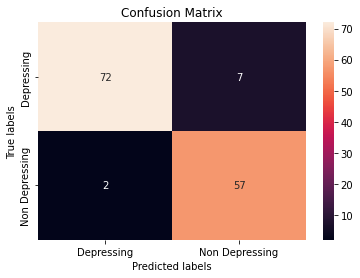

Accuracy Score 0.9347826086956522


In [26]:

cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [27]:
def predict_mood(id_song):
    
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]
    
    print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))

    if mood[0].upper() == 'NON DEPRESSING': 
        return 0
    else:
        return 1

    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

    

In [28]:
def playlistcheck(playlistid):
    mks = 0
    ttl = 0
    songs=get_songs_artist_ids_playlist(playlistid)
    temp = 0
    for song in songs[0]:
        mks=mks+predict_mood(song)
        ttl=ttl+1
        score=(mks/ttl)*100
        temp=score
    print(f"your playlist is {score}% depressing" )
    return temp
    

In [29]:
predict_mood('70LcF31zb1H0PyJoS1Sx1r')

Creep by Radiohead is a DEPRESSING song


1

In [28]:
scorer = playlistcheck('2UIXH2NZryRIrH8AJUHZ6L')

Sunset Lover by Petit Biscuit is a DEPRESSING song
Wait a Minute! by Various Artists is a NON DEPRESSING song
Running Up That Hill (A Deal With God) by Kate Bush is a DEPRESSING song
You've Got a Friend in Me - Remastered 2015 by Randy Newman is a DEPRESSING song
As If It's Your Last by BLACKPINK is a NON DEPRESSING song
DDU-DU DDU-DU by BLACKPINK is a NON DEPRESSING song
your playlist is 50.0% depressing


In [33]:
!designer

NameError: name 'playlistcheck' is not defined